# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:39:18.679602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:39:18.679665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:39:18.681262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-13, who has ID: A26W1UX7E3AW3J

In [2]:
parameters = {}

user = "users-13"
user_id = "A26W1UX7E3AW3J"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A26TWEWE7X9WIS,B000255MZG,B0002567T6,B000BHHDKC
1,AWPODHOB4GFWL,B000255MZG,B0001RTDGO,B00025YRMK
2,A2L6F74I87TPV1,B000255MZG,B003SJOLEQ,B00LWSPLS0
3,A1LZO0PRDBCM83,B000255MZG,B00BZ21BSW,B00I8PRS3Q
4,A1LZO0PRDBCM83,B000255N7S,B00I8PRS3Q,B000255MZG
...,...,...,...,...
11889,A8TWETXIQ28T3,B00V31HHVA,B00L1A0ESG,B00I33OWY6
11890,A21RMF49WK80JO,B00V31HHVA,B00FN60W0O,B00I323A0E
11891,AXIGRZQVE7M2R,B013ETUP58,B001F9CVRK,B00BUFTSV6
11892,AT6SCW8P6WBHU,B013ETUP58,B001F2117I,B00TYGQ0OG


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 11894
Number of sequences and targets after removal: 11513


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A26W1UX7E3AW3J
productID                 B00JXKJ7F2
purchased_before_1        B0002DHZIU
purchased_before_2        B001FJO8YY
Name: 321, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 11512
Number of sequences and targets after dropping duplicates: 11145


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 116
Number of unique product IDs in sequences: 8547


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B0002567T6', 'B000BHHDKC'],
        ['B003SJOLEQ', 'B00LWSPLS0'],
        ['B00BZ21BSW', 'B00I8PRS3Q'],
        ['B00I8PRS3Q', 'B000255MZG'],
        ['B004U8Z436', 'B0012KB47K'],
        ['B00J36A9MQ', 'B006YG12F6'],
        ['B000255MZG', 'B00J36A9MQ'],
        ['B007R5M7V6', 'B007EWLOQG'],
        ['B000YDQ90I', 'B000YDQ90I'],
        ['B0002565KM', 'B000BYN8PY']], dtype=object),
 array(['B000255MZG', 'B000255MZG', 'B000255MZG', 'B000255N7S',
        'B000255MZG', 'B00UBQI686', 'B006YG12F6', 'B000255MZG',
        'B0002565KM', 'B000XZQYQ6'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[1026, 10192],
        [34869, 98100],
        [71048, 88163],
        [88163, 721],
        [40853, 19856],
        [90204, 53655],
        [721, 90204],
        [56768, 55675],
        [19088, 19088],
        [957, 10471]], dtype=object),
 array([721, 721, 721, 729, 721, 112274, 53655, 721, 957, 18675],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 8881
Number of validation sequences: 1122
Number of test sequences: 1142

Number of train targets: 8881
Number of validation targets: 1122
Number of test targets: 1142

Number of classes (unique product IDs) in the train targets: 93
Number of classes in the validation targets: 100
Number of classes in the test targets: 116


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([43481, 45861], dtype=object),
 array([140616, 139603], dtype=object),
 array([19075, 19075], dtype=object),
 array([1026, 10192], dtype=object),
 array([735, 725], dtype=object),
 array([14340, 130910], dtype=object),
 array([37110, 38782], dtype=object),
 array([7258, 27157], dtype=object),
 array([116660, 500], dtype=object),
 array([957, 725], dtype=object)]

In [19]:
y_train[:10]

[721, 721, 721, 721, 721, 721, 721, 721, 721, 721]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/278 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0948 - f1_score: 0.0692 - f1_score_at_k: 0.0930 - hit_rate_at_k: 0.2605 - loss: 11.8427 - ndcg_at_k: 0.0599          

I0000 00:00:1714592373.019056    8656 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714592373.048168    8656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


278/278 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1456 - f1_score: 0.0596 - f1_score_at_k: 0.0991 - hit_rate_at_k: 0.3901 - loss: 9.2603 - ndcg_at_k: 0.0908 - val_accuracy: 0.1604 - val_f1_score: 0.1526 - val_f1_score_at_k: 0.3866 - val_hit_rate_at_k: 0.4132 - val_loss: 4.0667 - val_ndcg_at_k: 0.0967
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1677 - f1_score: 0.0731 - f1_score_at_k: 0.1044 - hit_rate_at_k: 0.4178 - loss: 3.6452 - ndcg_at_k: 0.1001 - val_accuracy: 0.1738 - val_f1_score: 0.1834 - val_f1_score_at_k: 0.3984 - val_hit_rate_at_k: 0.4167 - val_loss: 3.6893 - val_ndcg_at_k: 0.1006
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2099 - f1_score: 0.1322 - f1_score_at_k: 0.1399 - hit_rate_at_k: 0.4502 - loss: 3.3146 - ndcg_at_k: 0.1137 - val_accuracy: 0.1916 - val_f1_score: 0.2271 - val_f1_score_at_k: 0.4237 - val_hit_rate_at_k: 0.4115 - val_loss: 3.6743 - val_ndcg_at_k: 0.1030
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - a

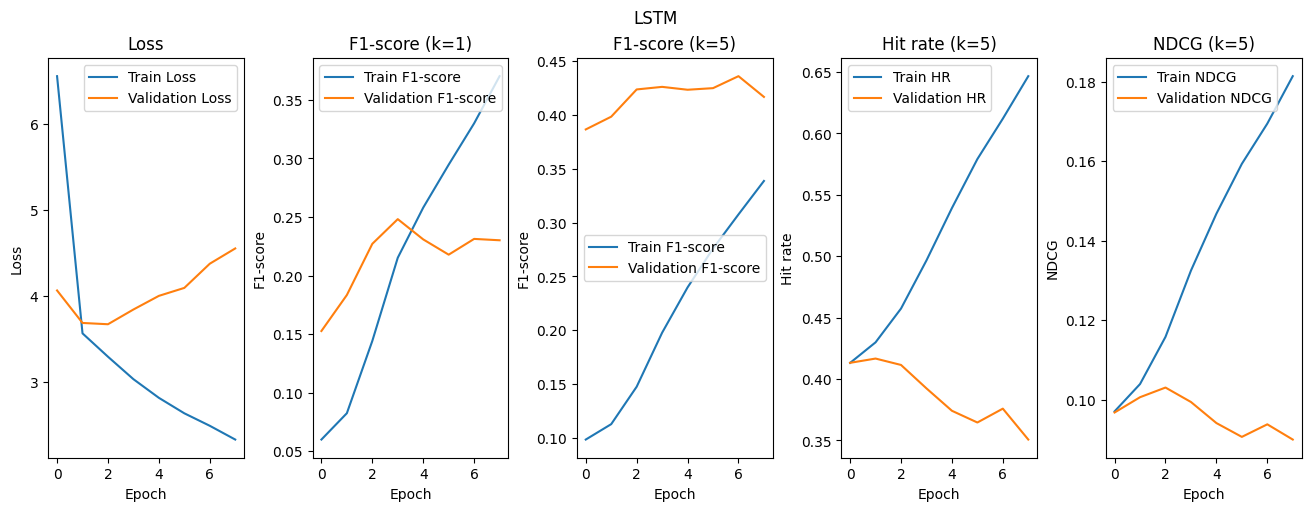

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1731 - f1_score: 0.2380 - f1_score_at_k: 0.4694 - hit_rate_at_k: 0.3865 - loss: 4.4424 - ndcg_at_k: 0.0960
Test loss: 4.8554
Test accuracy: 0.1559
Test F1@1: 0.2115
Test F1@5: 0.4333
Test HR@5: 0.3624
Test NDCG@5: 0.0894


In [32]:
parameters

{'user': 'users-13',
 'user_id': 'A26W1UX7E3AW3J',
 'number_of_sequences_and_targets_before_removal': 11894,
 'number_of_sequences_and_targets_after_removal': 11513,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 11145,
 'num_unique_product_ids_in_targets': 116,
 'num_unique_product_ids_in_sequences': 8547,
 'number_of_sequences_and_targets_train': 8881,
 'number_of_sequences_and_targets_validation': 1122,
 'number_of_sequences_and_targets_test': 1142,
 'number_of_unique_products_in_targets_train': 93,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 116,
 'model_lstm_test_loss': 4.855422019958496,
 'model_lstm_test_accuracy': 0.1559,
 'model_lstm_test_f1_score_k_1': 0.2115,
 'model_lstm_test_f1_score_k_5': 0.4333,
 'model_lstm_test_hr': 0.3624,
 'model_lstm_test_ndcg': 0.0894}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.1354 - f1_score: 0.0518 - f1_score_at_k: 0.0939 - hit_rate_at_k: 0.3765 - loss: 8.8650 - ndcg_at_k: 0.0867 - val_accuracy: 0.1595 - val_f1_score: 0.1509 - val_f1_score_at_k: 0.3951 - val_hit_rate_at_k: 0.4089 - val_loss: 3.9050 - val_ndcg_at_k: 0.0955
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1830 - f1_score: 0.0813 - f1_score_at_k: 0.1146 - hit_rate_at_k: 0.4415 - loss: 3.5052 - ndcg_at_k: 0.1065 - val_accuracy: 0.1889 - val_f1_score: 0.2073 - val_f1_score_at_k: 0.4110 - val_hit_rate_at_k: 0.4245 - val_loss: 3.6608 - val_ndcg_at_k: 0.1032
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2295 - f1_score: 0.1506 - f1_score_at_k: 0.1476 - hit_rate_at_k: 0.4644 - loss: 3.2319 - ndcg_at_k: 0.1196 - val_accuracy: 0.1925 - val_f1_score: 0.2349 - val_f1_score_at_k: 0.4447 - val_hit_rate_at_k: 0.4193 - val_loss: 3.6880 - val_ndcg_at_k: 0.1042
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7

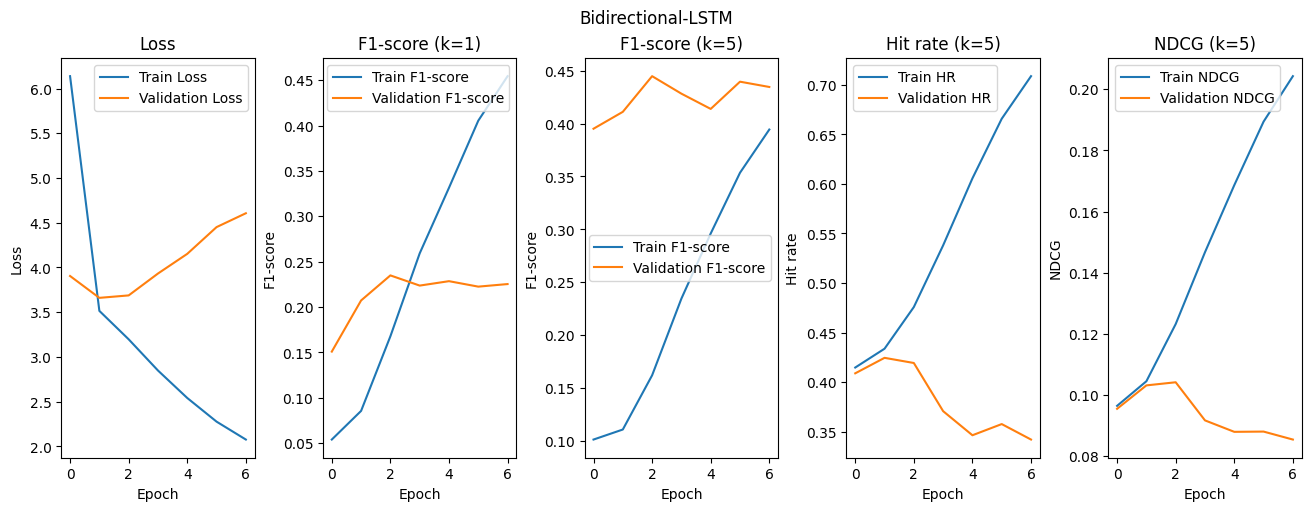

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1764 - f1_score: 0.2604 - f1_score_at_k: 0.4084 - hit_rate_at_k: 0.3177 - loss: 4.4979 - ndcg_at_k: 0.0848
Test loss: 4.9559
Test accuracy: 0.1576
Test F1@1: 0.228
Test F1@5: 0.3844
Test HR@5: 0.3029
Test NDCG@5: 0.079


In [37]:
parameters

{'user': 'users-13',
 'user_id': 'A26W1UX7E3AW3J',
 'number_of_sequences_and_targets_before_removal': 11894,
 'number_of_sequences_and_targets_after_removal': 11513,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 11145,
 'num_unique_product_ids_in_targets': 116,
 'num_unique_product_ids_in_sequences': 8547,
 'number_of_sequences_and_targets_train': 8881,
 'number_of_sequences_and_targets_validation': 1122,
 'number_of_sequences_and_targets_test': 1142,
 'number_of_unique_products_in_targets_train': 93,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 116,
 'model_lstm_test_loss': 4.855422019958496,
 'model_lstm_test_accuracy': 0.1559,
 'model_lstm_test_f1_score_k_1': 0.2115,
 'model_lstm_test_f1_score_k_5': 0.4333,
 'model_lstm_test_hr': 0.3624,
 'model_lstm_test_ndcg': 0.0894,
 'model_bi_lstm_test_loss': 4.955870628356934,
 'model_bi_lstm_test_accuracy': 0.1576,
 'model_bi_lstm_test_f1_score_k_1': 0.22

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.1384 - f1_score: 0.0497 - f1_score_at_k: 0.0988 - hit_rate_at_k: 0.3779 - loss: 9.1538 - ndcg_at_k: 0.0883 - val_accuracy: 0.1595 - val_f1_score: 0.1509 - val_f1_score_at_k: 0.3876 - val_hit_rate_at_k: 0.4002 - val_loss: 3.7826 - val_ndcg_at_k: 0.0949
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1818 - f1_score: 0.0830 - f1_score_at_k: 0.1057 - hit_rate_at_k: 0.4235 - loss: 3.5683 - ndcg_at_k: 0.1038 - val_accuracy: 0.1854 - val_f1_score: 0.2084 - val_f1_score_at_k: 0.3963 - val_hit_rate_at_k: 0.4106 - val_loss: 3.6542 - val_ndcg_at_k: 0.1021
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2106 - f1_score: 0.1247 - f1_score_at_k: 0.1398 - hit_rate_at_k: 0.4492 - loss: 3.3211 - ndcg_at_k: 0.1146 - val_accuracy: 0.1881 - val_f1_score: 0.2286 - val_f1_score_at_k: 0.4266 - val_hit_rate_at_k: 0.4193 - val_loss: 3.6572 - val_ndcg_at_k: 0.1035
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6

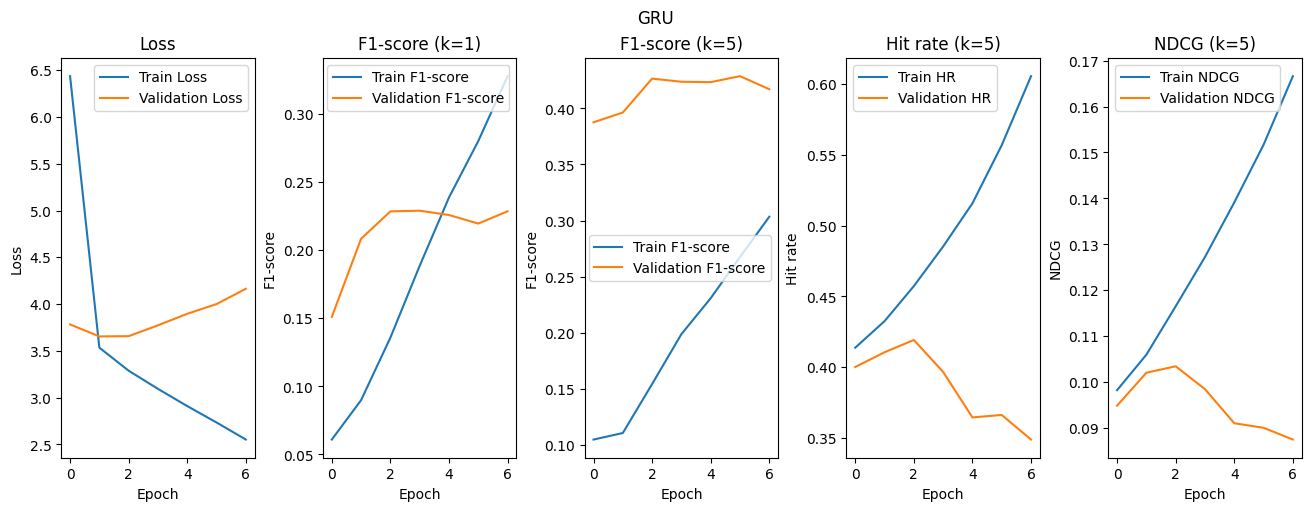

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1590 - f1_score: 0.2324 - f1_score_at_k: 0.4728 - hit_rate_at_k: 0.3841 - loss: 3.9655 - ndcg_at_k: 0.0930
Test loss: 4.3897
Test accuracy: 0.1681
Test F1@1: 0.2382
Test F1@5: 0.4343
Test HR@5: 0.3655
Test NDCG@5: 0.0918


In [42]:
parameters

{'user': 'users-13',
 'user_id': 'A26W1UX7E3AW3J',
 'number_of_sequences_and_targets_before_removal': 11894,
 'number_of_sequences_and_targets_after_removal': 11513,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 11145,
 'num_unique_product_ids_in_targets': 116,
 'num_unique_product_ids_in_sequences': 8547,
 'number_of_sequences_and_targets_train': 8881,
 'number_of_sequences_and_targets_validation': 1122,
 'number_of_sequences_and_targets_test': 1142,
 'number_of_unique_products_in_targets_train': 93,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 116,
 'model_lstm_test_loss': 4.855422019958496,
 'model_lstm_test_accuracy': 0.1559,
 'model_lstm_test_f1_score_k_1': 0.2115,
 'model_lstm_test_f1_score_k_5': 0.4333,
 'model_lstm_test_hr': 0.3624,
 'model_lstm_test_ndcg': 0.0894,
 'model_bi_lstm_test_loss': 4.955870628356934,
 'model_bi_lstm_test_accuracy': 0.1576,
 'model_bi_lstm_test_f1_score_k_1': 0.22

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.0333 - f1_score: 0.0252 - f1_score_at_k: 0.0689 - hit_rate_at_k: 0.1216 - loss: 11.3237 - ndcg_at_k: 0.0263 - val_accuracy: 0.0704 - val_f1_score: 0.0630 - val_f1_score_at_k: 0.2770 - val_hit_rate_at_k: 0.2760 - val_loss: 5.2438 - val_ndcg_at_k: 0.0578
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1472 - f1_score: 0.0715 - f1_score_at_k: 0.1118 - hit_rate_at_k: 0.4044 - loss: 4.0390 - ndcg_at_k: 0.0940 - val_accuracy: 0.1551 - val_f1_score: 0.1727 - val_f1_score_at_k: 0.3984 - val_hit_rate_at_k: 0.4089 - val_loss: 3.6796 - val_ndcg_at_k: 0.0960
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1855 - f1_score: 0.0932 - f1_score_at_k: 0.1148 - hit_rate_at_k: 0.4305 - loss: 3.5080 - ndcg_at_k: 0.1063 - val_accuracy: 0.1595 - val_f1_score: 0.1845 - val_f1_score_at_k: 0.4092 - val_hit_rate_at_k: 0.4106 - val_loss: 3.6540 - val_ndcg_at_k: 0.0968
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 

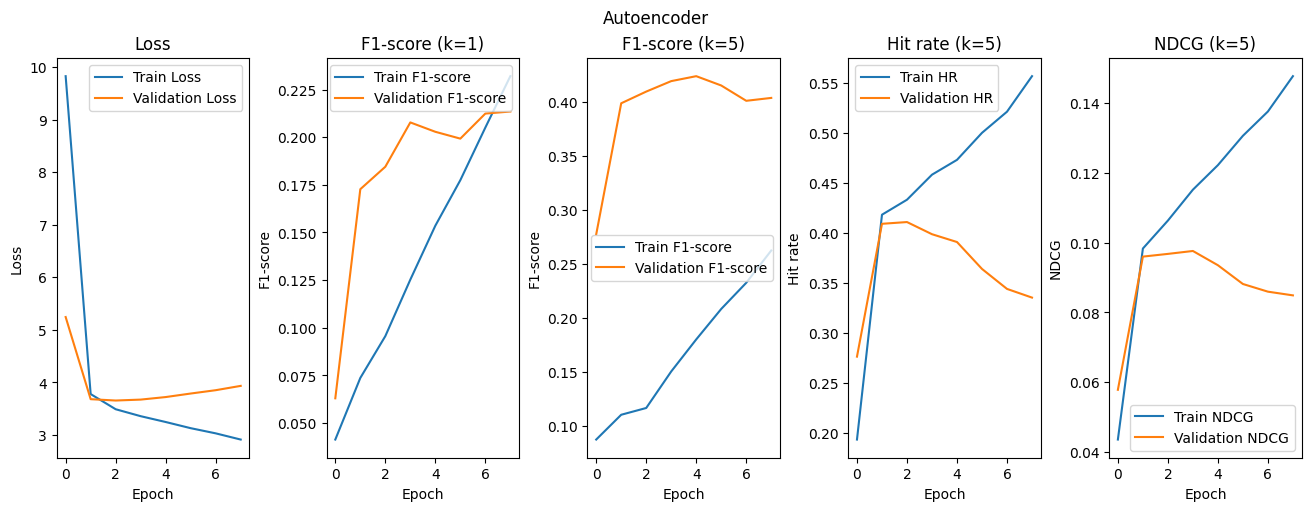

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1818 - f1_score: 0.2551 - f1_score_at_k: 0.4522 - hit_rate_at_k: 0.3735 - loss: 3.7145 - ndcg_at_k: 0.0956
Test loss: 4.0914
Test accuracy: 0.1646
Test F1@1: 0.2255
Test F1@5: 0.4043
Test HR@5: 0.3368
Test NDCG@5: 0.0855


In [47]:
parameters

{'user': 'users-13',
 'user_id': 'A26W1UX7E3AW3J',
 'number_of_sequences_and_targets_before_removal': 11894,
 'number_of_sequences_and_targets_after_removal': 11513,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 11145,
 'num_unique_product_ids_in_targets': 116,
 'num_unique_product_ids_in_sequences': 8547,
 'number_of_sequences_and_targets_train': 8881,
 'number_of_sequences_and_targets_validation': 1122,
 'number_of_sequences_and_targets_test': 1142,
 'number_of_unique_products_in_targets_train': 93,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 116,
 'model_lstm_test_loss': 4.855422019958496,
 'model_lstm_test_accuracy': 0.1559,
 'model_lstm_test_f1_score_k_1': 0.2115,
 'model_lstm_test_f1_score_k_5': 0.4333,
 'model_lstm_test_hr': 0.3624,
 'model_lstm_test_ndcg': 0.0894,
 'model_bi_lstm_test_loss': 4.955870628356934,
 'model_bi_lstm_test_accuracy': 0.1576,
 'model_bi_lstm_test_f1_score_k_1': 0.22

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A26W1UX7E3AW3J', 'sequence': [4076, 24823], 'target': 92815}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 0.0
NDCG@50: 0.0
-------------
HT@100: 0.0
NDCG@100: 0.0
-------------
HT@200: 0.0
NDCG@200: 0.0
-------------
HT@300: 0.0
NDCG@300: 0.0
-------------
HT@400: 0.0
NDCG@400: 0.0
-------------
HT@500: 0.0
NDCG@500: 0.0
-------------
